In [131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
def check_ (x_, y_, y_pred, centers, epsilon, e_min):
    error = np.abs(y_ - y_pred)
    if error <= e_min:
        return False   # age khata az had mojaz kamtar bashe niazi be roshd nadarim
    
    if len(centers) == 0:
        return True  # age center nadarim pas neuron nadarim pas bayad neuron besazim
    
    x_ = np.array(x_)
    centers_ = np.array(centers)
    
    distances = np.linalg.norm(centers_ - x_, axis = 1)
    distance_min = np.min(distances)
    
    
    if distance_min > epsilon: # data be andaze kafi door az baghie hast?
        return True  # kahta ziyad + distance ziyad = neuron jadid
    else:
        return False # khata ziyad , fasele kam = weights niyaz daran update beshan
    

In [5]:
epsilon = 1
e_min = 0.5
center = [[0,0], [2,2]]

print(f"Growth test (Epsilon={epsilon}, Emin={e_min})")

# data outlier ba khata ziyad = bayda roshd bokone
x1 = [20, 20]
y_true1 = 5
y_pred1 = 2
result1 = check_ (x1, y_true1,y_pred1,center,  epsilon, e_min)
print(result1)

Growth test (Epsilon=1, Emin=0.5)
True


In [7]:
# data tekrari ba khataye ziyad = needs an update , pas roshd nemikone
x2 = [0.01, 0.01]
y_true2 = 5
y_pred2 = 2
result2 = check_ (x2, y_true2,y_pred2,center, epsilon, e_min)
print(result2)

False


In [9]:
# data outlier ba khataye kam = naabayad roshd kone
x3 = [15,15]
y_true3 = 5
y_pred3 = 4.85
result3 = check_(x3, y_true3,y_pred3, center,epsilon, e_min)
print(result3)

False


# Section 2

In [240]:
import numpy as np

class MRAN_rbfnn:
    def __init__(self, input_d,
                 
                 e_min = 0.1,        
                 epsilon_max = 1.0,  
                 epsilon_min = 0.005,
                 kappa = 0.8,        
                 # LMS
                 lr_w = 0.05,      
                 
                 # pruning
                 prun_thresh = 0.05, # delta
                 prun_window = 60,   
                 
                 decay_rate = 0.999  
                 ):
        
        self.input_d = input_d
        self.e_min = e_min
        
        self.epsilon = epsilon_max
        self.epsilon_limit = epsilon_min
        
        self.kappa = kappa 
        self.decay = decay_rate
        
        self.lr_w = lr_w
        
        self.prun_delta = prun_thresh
        self.prune_M = prun_window
        
        self.centers = []
        self.sigmas = []
        self.weights = []
        
        self.prune_counters = []
        
        self.history_neurons = []
        self.history_rmse = []
        self.history_epsilon = []
        
    def gaussian_kernel(self, x, mu, sigma):
        # rbf
        dist_sq = np.sum((x - mu)**2)
        return np.exp(-dist_sq / (sigma ** 2))
    
    def predict(self, x):
        # y = sum(w * phi) 
        if not self.centers:
            return 0.0
        
        phi_ = [self.gaussian_kernel(x, mu_, sigma_) for mu_, sigma_ in zip(self.centers, self.sigmas)]
        
        return np.dot(phi_, self.weights)
   
    def train_(self, x, y_true, epoch=None):
     
        x = np.asarray(x)
        y_true = np.array(y_true).item() if np.ndim(y_true) > 0 else y_true
        
        y_pred = self.predict(x)
        error = y_true - y_pred  
        absolute_error = np.abs(error)
        
        growth_allowed = False
        distance_min = float('inf')
        
        if len(self.centers) > 0:
            distances = [np.linalg.norm(x - c) for c in self.centers]
            distance_min = np.min(distances)
            
            if absolute_error > self.e_min and distance_min > self.epsilon:
                # khata ziyade, fasele ham ziyade, roshd mikonim
                growth_allowed = True
        else:
            # network empty; pas roshd kon hatman
            growth_allowed = True
            distance_min = self.epsilon 
            
        if growth_allowed:
            
            self.centers.append(x.copy()) 
            self.weights.append(error)    # init weight = current error
            
            
            if len(self.centers) == 1:
                sigma_ = self.epsilon
            else:
                sigma_ = max(self.kappa * distance_min, self.epsilon_limit)
            
            self.sigmas.append(sigma_)
            self.prune_counters.append(0) 
        
        else:
            # lms baraye learn , we didnt roshd so we need update
            if len(self.centers) > 0:
                phis = [self.gaussian_kernel(x, mu_, sigma_) for mu_, sigma_ in zip(self.centers, self.sigmas)]
                
                #  w(n) = w(n-1) + eta * e * phi
                for k in range(len(self.centers)):
                    # Δw = η * e * φ
                    self.weights[k] += self.lr_w * error * phis[k]
                    
                   
                    
    
        # prune mikonim 
        if len(self.centers) > 0:
            phis = np.array([self.gaussian_kernel(x, mu_, sigma_) for mu_, sigma_ in zip(self.centers, self.sigmas)])
         
            contributions = np.array(self.weights) * phis
            
            max_contribution = np.max(np.abs(contributions))
            
   
            if max_contribution > 1e-12:
                normalized_contribution = np.abs(contributions) / max_contribution
            else:
                normalized_contribution = np.zeros_like(contributions)
                
            indices_to_remove = []
            
            for k in range(len(self.centers)):
                if normalized_contribution[k] < self.prun_delta:
                    # means this neuron is not important 
                    self.prune_counters[k] += 1 
                else:
                    self.prune_counters[k] = 0 # means this neuron is good 
                
        
                if self.prune_counters[k] > self.prune_M:
                    indices_to_remove.append(k)
            
        
            for index in sorted(indices_to_remove , reverse = True):
                self.centers.pop(index)
                self.sigmas.pop(index)
                self.weights.pop(index)
                self.prune_counters.pop(index)
            
        
       
        # tatbigh dadan hyper param ha
        self.epsilon = max(self.epsilon * self.decay, self.epsilon_limit)    
        
     
        self.history_neurons.append(len(self.centers))
        self.history_rmse.append(absolute_error**2) 
        self.history_epsilon.append(self.epsilon)

In [241]:
df = pd.read_csv('1000Sample_data_ball&beam.csv')
df.head()

,Y[t-1],Y[t-2],U[t-1],Y[t]
0,0.000000,0.000000,0.025130,0.000016
1,0.000016,0.000000,0.050244,0.000143
2,0.000143,0.000016,0.075327,0.000570
3,0.000570,0.000143,0.100362,0.001581
4,0.001581,0.000570,0.125333,0.003549


In [242]:
X = df[["Y[t-1]", "Y[t-2]", "U[t-1]"]]
Y = df[["Y[t]"]]

In [243]:
X_min, X_max = X.min(axis=0), X.max(axis=0)
Y_min, Y_max = Y.min(), Y.max()

X_norm = (X - X_min) / (X_max - X_min + 1e-8)
Y_norm = (Y - Y_min) / (Y_max - Y_min + 1e-8)

In [244]:
train_size = int(0.7 * len(X))
X_train, X_test = X_norm[:train_size], X_norm[train_size:]
y_train, y_test = Y_norm[:train_size], Y_norm[train_size:]

In [245]:
if isinstance(X_train, pd.DataFrame) or isinstance(X_train, pd.Series):
    X_train = X_train.values
    y_train = y_train.values
    
if isinstance(X_test, pd.DataFrame) or isinstance(X_test, pd.Series):
    X_test = X_test.values
    y_test = y_test.values

In [246]:
print(f"Train Size: {len(X_train)} | Test Size: {len(X_test)}")

Train Size: 700 | Test Size: 300


In [ ]:
import itertools
e_min_values = [0.01, 0.05, 0.1, 0.2]
epsilon_values = [0.1, 0.5, 0.8, 1.0, 1.2]

best_score = float('inf')
best_params = {}
best_model = None

print(f"{'E_min':<10} | {'Epsilon':<10} | {'Test RMSE':<15} | {'Neurons':<10}")
print("-" * 55)

for e_val, eps_val in itertools.product(e_min_values, epsilon_values):
    
    model = MRAN_rbfnn(
        input_d=3,
        e_min=e_val,
        epsilon_max=eps_val,
        epsilon_min=0.02,   
        kappa=0.8,         
        lr_w=0.05,         
        prun_thresh=0.1,   
        prun_window=60,    
        decay_rate=0.999    
    )
    
    EPOCHS_SEARCH = 20
    indices = np.arange(len(X_train))
    
    for epoch in range(EPOCHS_SEARCH):
        np.random.shuffle(indices) 
        for i in indices:
            model.train_(X_train[i], y_train[i], epoch=epoch)
            
    y_pred = []
    for i in range(len(X_test)):
        y_pred.append(model.predict(X_test[i]))
    
    y_pred = np.array(y_pred)
    y_test_flat = y_test.flatten() if hasattr(y_test, 'flatten') else np.array(y_test).flatten()
    rmse = np.sqrt(np.mean((y_test_flat - y_pred)**2))
    
    print(f"{e_val:<10} | {eps_val:<10} | {rmse:.6f}        | {len(model.centers):<10}")
    
    if rmse < best_score:
        best_score = rmse
        best_params = {'e_min': e_val, 'epsilon': eps_val}
        best_model = model 

print("=" * 55)
print(f"Best Parameters found: {best_params}")
print(f"Best RMSE: {best_score}")

E_min      | Epsilon    | Test RMSE       | Neurons   
-------------------------------------------------------
0.01       | 0.1        | 0.022649        | 27        
0.01       | 0.5        | 0.029124        | 27        
0.01       | 0.8        | 0.023755        | 20        
0.01       | 1.0        | 0.024496        | 20        
0.01       | 1.2        | 0.032014        | 21        
0.05       | 0.1        | 0.021612        | 17        
0.05       | 0.5        | 0.021492        | 16        
0.05       | 0.8        | 0.020974        | 16        
0.05       | 1.0        | 0.026815        | 15        
0.05       | 1.2        | 0.021309        | 13        
0.1        | 0.1        | 0.025127        | 10        
0.1        | 0.5        | 0.024490        | 10        
0.1        | 0.8        | 0.029405        | 8         
0.1        | 1.0        | 0.040357        | 9         
0.1        | 1.2        | 0.023893        | 6         
0.2        | 0.1        | 0.041797        | 4         
0.2      

In [326]:
mran = MRAN_rbfnn(
    input_d = 3,
    e_min = 0.05,      
    epsilon_max = 0.8, 
    epsilon_min = 0.02, 
    kappa = 0.8,
    prun_thresh = 0.1, 
    prun_window = 60,
    lr_w = 0.05,        
    decay_rate = 0.999
)

In [327]:
print(f"{'Epoch':<6} | {'Neurons':<8} | {'Train RMSE':<12} | {'Epsilon':<10}")
print("-" * 50)

EPOCHS = 30 
for epoch in range(EPOCHS):
    epoch_errors = []
    for i in range(len(X_train)):
        mran.train_(X_train[i], y_train[i], epoch=epoch)
        pred = mran.predict(X_train[i])
        epoch_errors.append((y_train[i].item() - pred)**2)
    train_rmse = np.sqrt(np.mean(epoch_errors))
    print(f"{epoch+1:<6} | {len(mran.centers):<8} | {train_rmse:.5f}    | {mran.epsilon:.4f}")

Epoch  | Neurons  | Train RMSE   | Epsilon   
--------------------------------------------------
1      | 2        | 0.05399    | 0.3971
2      | 3        | 0.05258    | 0.1971
3      | 3        | 0.04357    | 0.0979
4      | 7        | 0.02792    | 0.0486
5      | 7        | 0.02294    | 0.0241
6      | 8        | 0.02282    | 0.0200
7      | 8        | 0.02270    | 0.0200
8      | 8        | 0.02270    | 0.0200
9      | 8        | 0.02270    | 0.0200
10     | 8        | 0.02270    | 0.0200
11     | 8        | 0.02270    | 0.0200
12     | 8        | 0.02270    | 0.0200
13     | 8        | 0.02270    | 0.0200
14     | 8        | 0.02270    | 0.0200
15     | 8        | 0.02270    | 0.0200
16     | 8        | 0.02270    | 0.0200
17     | 8        | 0.02270    | 0.0200
18     | 8        | 0.02270    | 0.0200
19     | 8        | 0.02270    | 0.0200
20     | 8        | 0.02270    | 0.0200
21     | 8        | 0.02270    | 0.0200
22     | 8        | 0.02270    | 0.0200
23     | 8        | 0.0

In [328]:
print("\nEvaluation on Test Data...")
y_pred_mran = []
for i in range(len(X_test)):
    pred = mran.predict(X_test[i])
    y_pred_mran.append(pred)

y_pred_mran = np.array(y_pred_mran)
y_test_flat = y_test.flatten() if hasattr(y_test, 'flatten') else np.array(y_test).flatten()

rmse_mran = np.sqrt(np.mean((y_test_flat - y_pred_mran)**2))
rmse_mran


Evaluation on Test Data...


0.08073409917795549

In [329]:
rmse_static = 0.0005480327488016946
neurons_static = 200

In [330]:

print("\n" + "="*40)
print("="*40)
print(f"{'Model':<15} | {'Neurons':<10} | {'RMSE Test':<12}")
print("-" * 40)
print(f"{'Static RBF':<15} | {neurons_static:<10} | {rmse_static:<12}")
print(f"{'Adaptive M-RAN':<15} | {len(mran.centers):<10} | {rmse_mran:.6f}")
print("="*40)


Model           | Neurons    | RMSE Test   
----------------------------------------
Static RBF      | 200        | 0.0005480327488016946
Adaptive M-RAN  | 8          | 0.080734


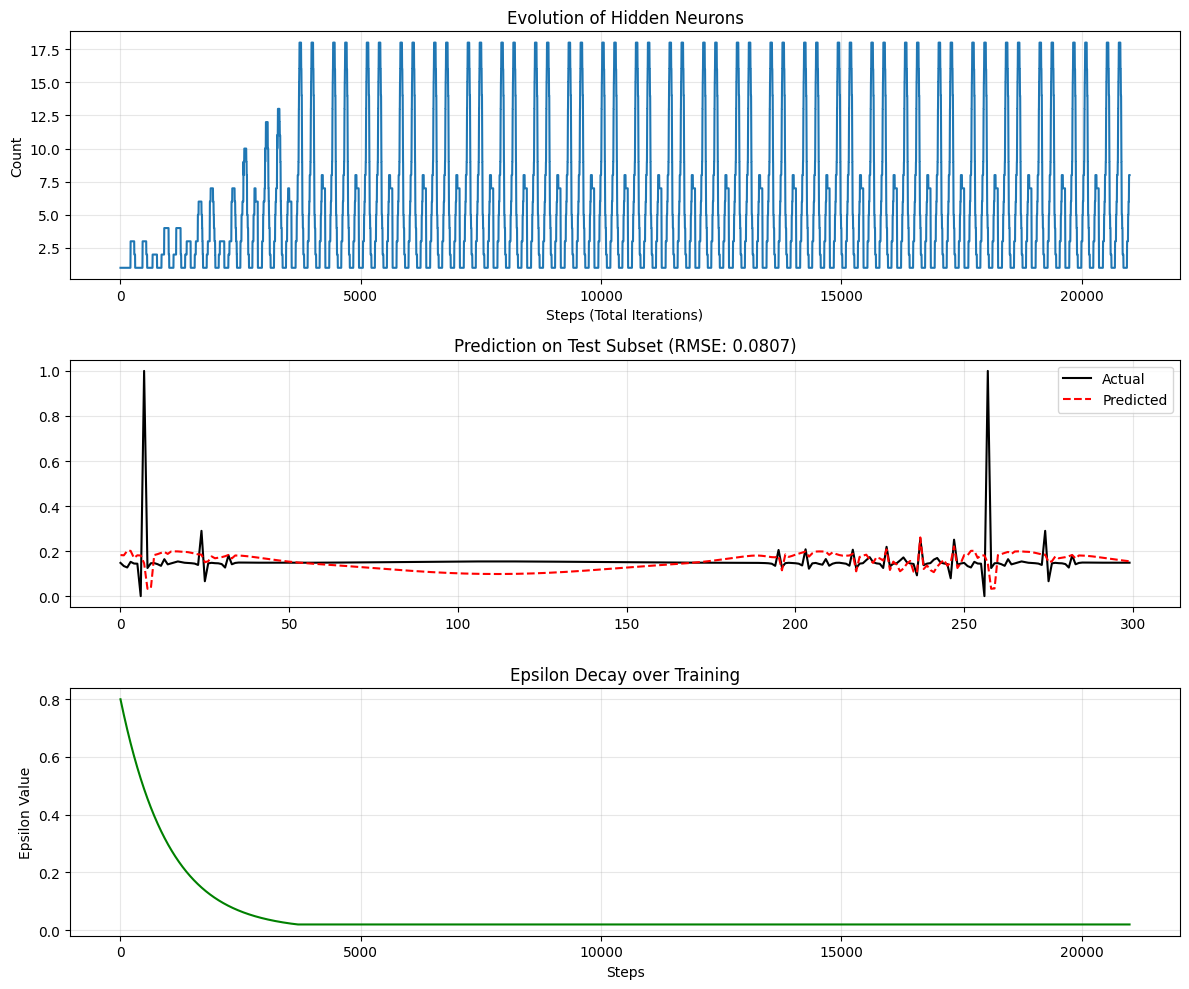

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(mran.history_neurons)
plt.title('Evolution of Hidden Neurons')
plt.ylabel('Count')
plt.xlabel('Steps (Total Iterations)')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)

limit = 300 
plt.plot(y_test_flat[:limit], 'k-', label='Actual', linewidth=1.5)
plt.plot(y_pred_mran[:limit], 'r--', label='Predicted', linewidth=1.5)
plt.title(f'Prediction on Test Subset (RMSE: {rmse_mran:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(mran.history_epsilon, color='green')
plt.title('Epsilon Decay over Training')
plt.ylabel('Epsilon Value')
plt.xlabel('Steps')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## shuffle

In [332]:
mran_shuffle = MRAN_rbfnn(
    input_d = 3,
    e_min = 0.05,      
    epsilon_max = 0.8, 
    epsilon_min = 0.02, 
    kappa = 0.8,
    prun_thresh = 0.1, 
    prun_window = 60,
    lr_w = 0.05,        
    decay_rate = 0.999
)

In [333]:
print(f"{'Epoch':<6} | {'Neurons':<8} | {'Train RMSE':<12} | {'Epsilon':<10}")
print("-" * 50)

N = len(X_train)
EPOCHS = 30
indices = np.arange(N)

for epoch in range(EPOCHS):
    np.random.shuffle(indices)
    
    epoch_errors = []
    
    for i in indices:
        
        mran_shuffle.train_(X_train[i], y_train[i], epoch=epoch)

        pred = mran_shuffle.predict(X_train[i])
        epoch_errors.append((y_train[i].item() - pred)**2)
    
    train_rmse = np.sqrt(np.mean(epoch_errors))
    print(f"{epoch+1:<6} | {len(mran_shuffle.centers):<8} | {train_rmse:.5f}    | {mran_shuffle.epsilon:.4f}")

Epoch  | Neurons  | Train RMSE   | Epsilon   
--------------------------------------------------
1      | 4        | 0.05449    | 0.3971
2      | 4        | 0.05074    | 0.1971
3      | 11       | 0.05275    | 0.0979
4      | 14       | 0.02692    | 0.0486
5      | 16       | 0.02178    | 0.0241
6      | 16       | 0.01941    | 0.0200
7      | 18       | 0.01934    | 0.0200
8      | 15       | 0.01845    | 0.0200
9      | 19       | 0.01797    | 0.0200
10     | 18       | 0.01827    | 0.0200
11     | 16       | 0.01699    | 0.0200
12     | 18       | 0.01871    | 0.0200
13     | 18       | 0.01756    | 0.0200
14     | 14       | 0.01855    | 0.0200
15     | 16       | 0.02190    | 0.0200
16     | 18       | 0.02010    | 0.0200
17     | 17       | 0.01876    | 0.0200
18     | 17       | 0.01779    | 0.0200
19     | 15       | 0.01631    | 0.0200
20     | 14       | 0.01888    | 0.0200
21     | 15       | 0.01853    | 0.0200
22     | 14       | 0.01722    | 0.0200
23     | 17       | 0.0

In [334]:
print("\nEvaluation on Test Data...")
y_pred_mran = []
for i in range(len(X_test)):
    pred = mran_shuffle.predict(X_test[i])
    y_pred_mran.append(pred)

y_pred_mran = np.array(y_pred_mran)
y_test_flat = y_test.flatten() if hasattr(y_test, 'flatten') else np.array(y_test).flatten()

rmse_mran = np.sqrt(np.mean((y_test_flat - y_pred_mran)**2))

print(f"Final Test RMSE: {rmse_mran:.6f}")
print(f"Final Neurons: {len(mran_shuffle.centers)}")


Evaluation on Test Data...
Final Test RMSE: 0.026800
Final Neurons: 18


In [335]:
rmse_static = 0.0005480327488016946
neurons_static = 200

In [ ]:

print("="*40)
print(f"{'Model':<15} | {'Neurons':<10} | {'RMSE Test':<12}")
print("-" * 40)
print(f"{'Static RBF':<15} | {neurons_static:<10} | {rmse_static:<12}")
print(f"{'Adaptive M-RAN':<15} | {len(mran.centers):<10} | {rmse_mran:.6f}")
print("="*40)


Model           | Neurons    | RMSE Test   
----------------------------------------
Static RBF      | 200        | 0.0005480327488016946
Adaptive M-RAN  | 8          | 0.026800


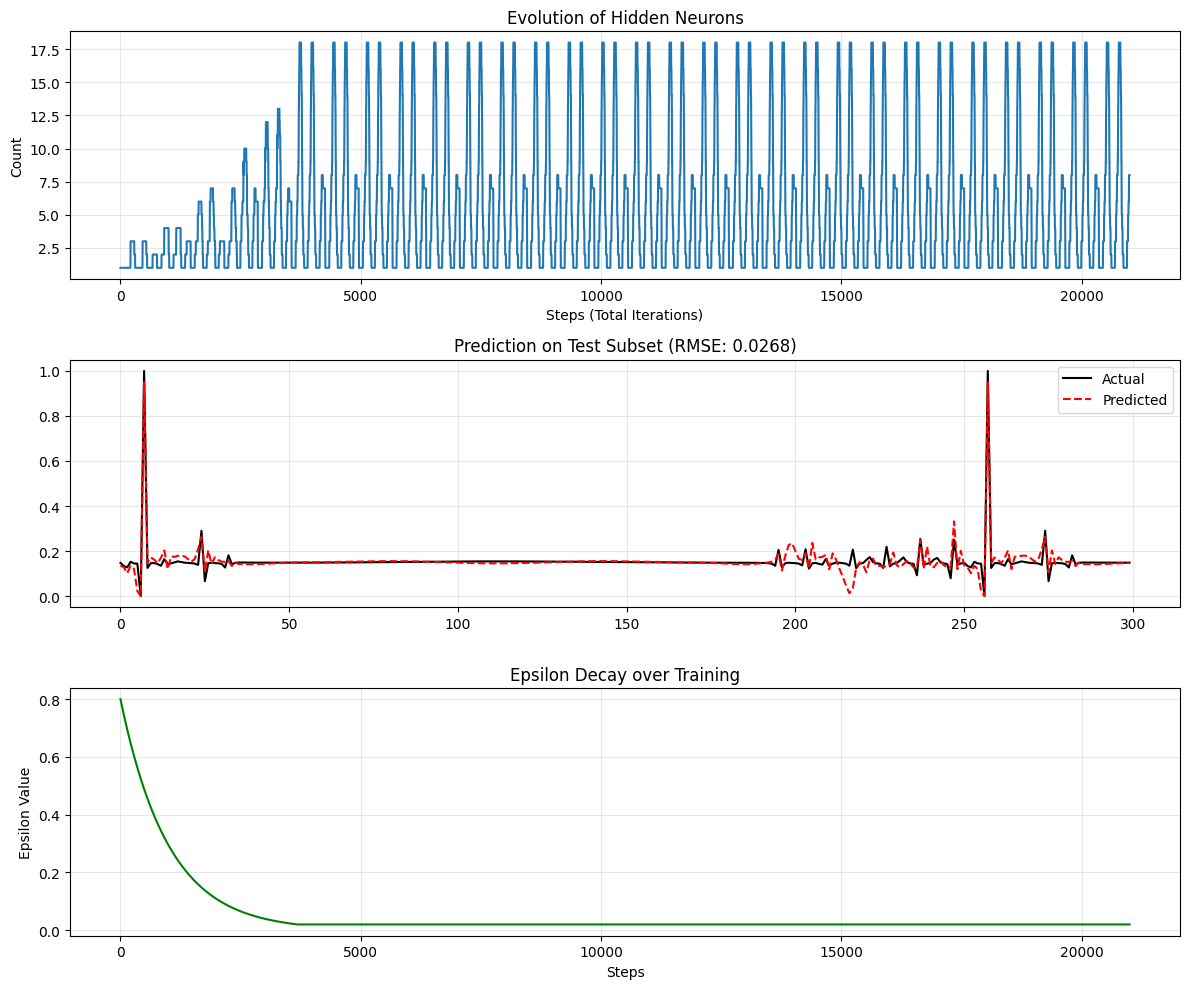

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(mran.history_neurons)
plt.title('Evolution of Hidden Neurons')
plt.ylabel('Count')
plt.xlabel('Steps (Total Iterations)')
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 2)

limit = 300 
plt.plot(y_test_flat[:limit], 'k-', label='Actual', linewidth=1.5)
plt.plot(y_pred_mran[:limit], 'r--', label='Predicted', linewidth=1.5)
plt.title(f'Prediction on Test Subset (RMSE: {rmse_mran:.4f})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 1, 3)
plt.plot(mran.history_epsilon, color='green')
plt.title('Epsilon Decay over Training')
plt.ylabel('Epsilon Value')
plt.xlabel('Steps')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()